In [ ]:
# recreating OECD Social Expenditure by income quintile graph (figure 5)
# http://www.oecd.org/els/soc/OECD2014-Social-Expenditure-Update-Nov2014-8pages.pdf
# and comparing 2011 and 2014

# full original data is here
# http://oe.cd/idd 

# BUT OECD sites all seem a bit iffy (so I ended up sending a begging email and they just send me the data series)

In [492]:

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [493]:
import holoviews as hv
hv.notebook_extension()

from bqplot import (
    LogScale, LinearScale, OrdinalColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip, Hist
)

from ipywidgets import HBox, VBox, IntSlider, Play, jslink, Layout, Dropdown
import ipywidgets
%matplotlib inline

In [494]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_publications_folder = "../BES_analysis_publications/"
if not os.path.exists( BES_publications_folder ):
    os.makedirs( BES_publications_folder )

BES_publications_OECD_SE = BES_publications_folder + os.sep + "OECD_Social_Expenditure" + os.sep
if not os.path.exists( BES_publications_OECD_SE ):
    os.makedirs( BES_publications_OECD_SE )    
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [495]:
OECD_data_files = BES_small_data_files + os.sep + "Other_datasets"+ os.sep + "OECD_Social_Expenditure" + os.sep

In [496]:
SE_2011 = pd.read_csv(OECD_data_files+"IDD-share-transfers-2011.csv")
SE_2014 = pd.read_csv(OECD_data_files+"IDD-share-transfers-2014.csv")

In [497]:
state_label = "OECD States"
quintile_label = "Recipient Disposable Income Quintiles"
share_label = "%Share of Public Social Benefits"
quintile_label_list = ['Q1 (Lowest Fifth)',"Q2","Q3","Q4",'Q5 (Highest Fifth)']

# Good distinct colours!: Red, Orange, Yellow, Green, Blue
palette = {quintile_label_list[0]: "Blue",
           quintile_label_list[1]: "Green",
           quintile_label_list[2]: "Yellow",
           quintile_label_list[3]: "Orange",
           quintile_label_list[4]: "Red"    }


In [498]:
SE_2011.columns = [state_label]+quintile_label_list
SE_2014.columns = [state_label]+quintile_label_list

In [499]:
SE_2011.loc[SE_2011[state_label]=="OECD",state_label] = "OECD Mean"
SE_2014.loc[SE_2014[state_label]=="OECD",state_label] = "OECD Mean"

In [500]:
set(SE_2011[state_label].values).symmetric_difference(set(SE_2014[state_label].values))
# Latvia in 2014 dataset, but not 2011

SE_2014 = SE_2014.drop( SE_2014[ SE_2014[state_label]=="Latvia" ].index ).reset_index(drop=True)

# Quintiles by Equivalised Disposable Income

In [501]:
# make sure all shares add up to 100%

SE_2011[quintile_label_list] = 100*SE_2011[quintile_label_list].apply(lambda x: x/SE_2011[quintile_label_list].sum(axis=1))
SE_2014[quintile_label_list] = 100*SE_2014[quintile_label_list].apply(lambda x: x/SE_2014[quintile_label_list].sum(axis=1))


In [502]:
SE_sum = SE_2014.copy()

SE_sum[quintile_label_list] = SE_2014[quintile_label_list] + SE_2011[quintile_label_list]
SE_sum["Q5-Q1"] = SE_sum[quintile_label_list[-1]] - SE_sum[quintile_label_list[0]]

sorted_States = SE_sum.sort_values(by="Q5-Q1",ascending=True)[ state_label ]

In [503]:
# order all states by 2011 Q5 values

SE_2011[state_label] = SE_2011[state_label].astype('category').cat.reorder_categories(sorted_States, ordered=True)
SE_2014[state_label] = SE_2014[state_label].astype('category').cat.reorder_categories(sorted_States, ordered=True)

SE_2011 = SE_2011.sort_values(by=state_label,ascending=True)
SE_2014 = SE_2014.sort_values(by=state_label,ascending=True)

data_by_year = {"2011":SE_2011, "2014":SE_2014}

In [504]:
def flatten_df(data_by_year, year, quintile_label_list, show_all_quintiles, share_label):
    # data_by_year: dictionary of datasets by year
    # year str "2011"/"2014"

    if year == "difference":
        SE_df = data_by_year["2011"].copy()
        SE_df[quintile_label_list] = data_by_year["2014"][quintile_label_list] - data_by_year["2011"][quintile_label_list]        
        title = "Change from 2011 to 2014- " + share_label
    else:
        SE_df = data_by_year[year].copy()
        title = year + "- " + share_label

    
    if show_all_quintiles:
        drop_list = []
        title = title + " paid to people in all income quintiles"
    else:
        drop_list = quintile_label_list[1:-1]
        title = title + " paid to people with lowest and highest income quintiles"
    
    SE_flat = SE_df.drop(drop_list,axis=1)
    SE_flat.index = SE_flat[state_label]
    SE_flat = SE_flat.drop(state_label,axis=1).stack().reset_index()
    SE_flat.columns = [state_label, quintile_label, share_label]
    return (SE_flat , title )

In [505]:
def annotate(ax, title, year):
    plt.title(title)
    plt.xticks(rotation=90)
    if year == "difference":
        ax.axhline(y=0,  xmin=0, xmax=1, alpha=.5, dashes=[5, 5], color='grey')
    else:
        ax.axhline(y=20, xmin=0, xmax=1, alpha=.5, dashes=[5, 5], color='grey')
        plt.ylim(0, 60)
        
        
    note_annotation = "Notes: "+quintile_label+"(Equivalised)"+", "+share_label+"(Paid in cash)"+"\n"\
        "Total population, States ordered by increasing Q5 (average of 2011 and 2014)"
    ax.annotate(note_annotation, (0,0), (0, -105),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 8) 

    source_annotation = "Source: Data from OECD Income Distribution database, via http://oe.cd/idd"
    ax.annotate(source_annotation, (0,0), (0, -130),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 8) 

In [506]:
def plot_script():

    data , title = flatten_df(data_by_year, year, quintile_label_list, show_all_quintiles, share_label)
    f, ax = plt.subplots(figsize=figsize)
    ax = plot_fn( ax=ax, x=state_label, y=share_label, hue=quintile_label, data=data, palette = palette )
    annotate(ax,title=title,year=year)
    f.savefig( BES_publications_OECD_SE+title+".png", bbox_inches='tight' )

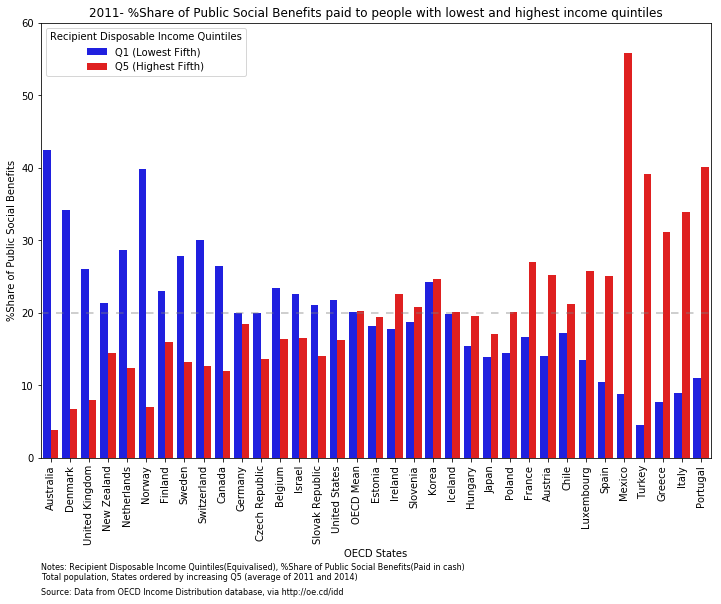

In [507]:
year = "2011"
show_all_quintiles = False
diff = False
figsize = (12,8)
plot_fn = sns.barplot

plot_script()

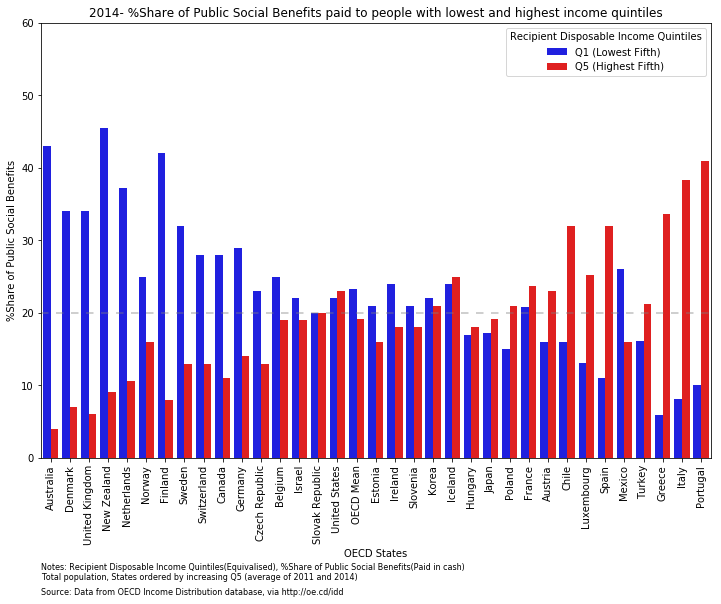

In [508]:
year = "2014"
show_all_quintiles = False
diff = False
figsize = (12,8)
plot_fn = sns.barplot

plot_script()

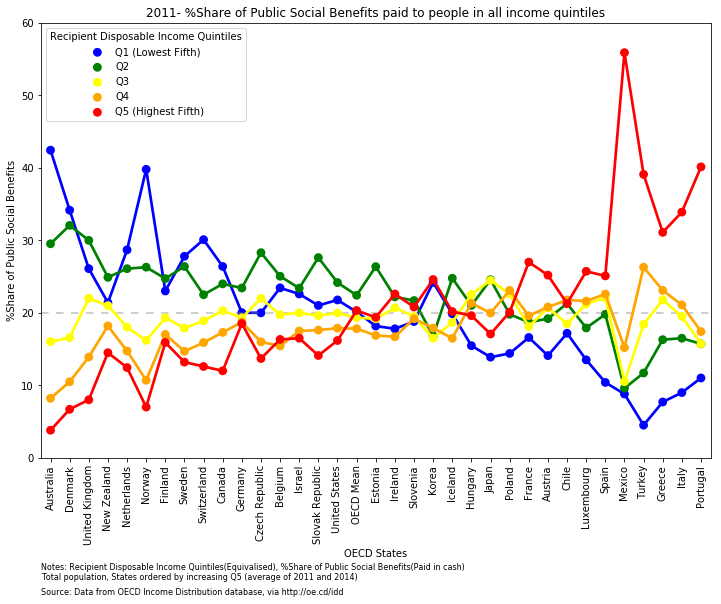

In [509]:
year = "2011"
show_all_quintiles = True
diff = False
figsize = (12,8)
plot_fn = sns.pointplot

plot_script()

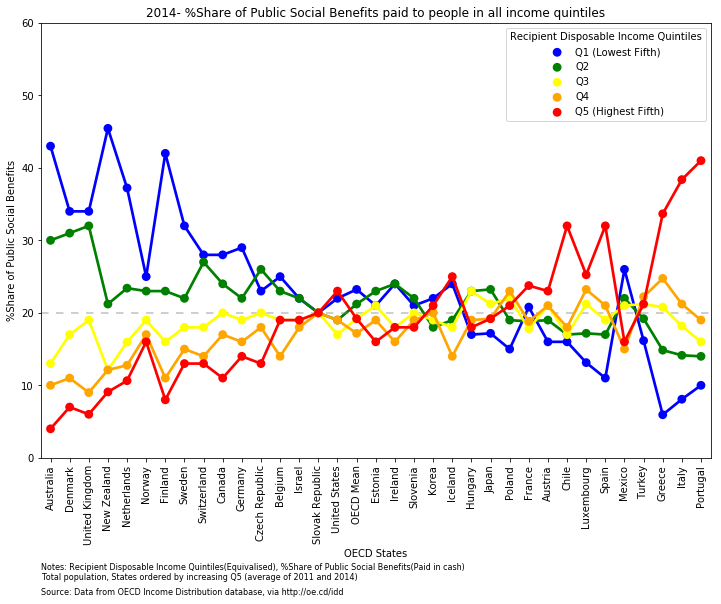

In [510]:
year = "2014"
show_all_quintiles = True
diff = False
figsize = (12,8)
plot_fn = sns.pointplot

plot_script()

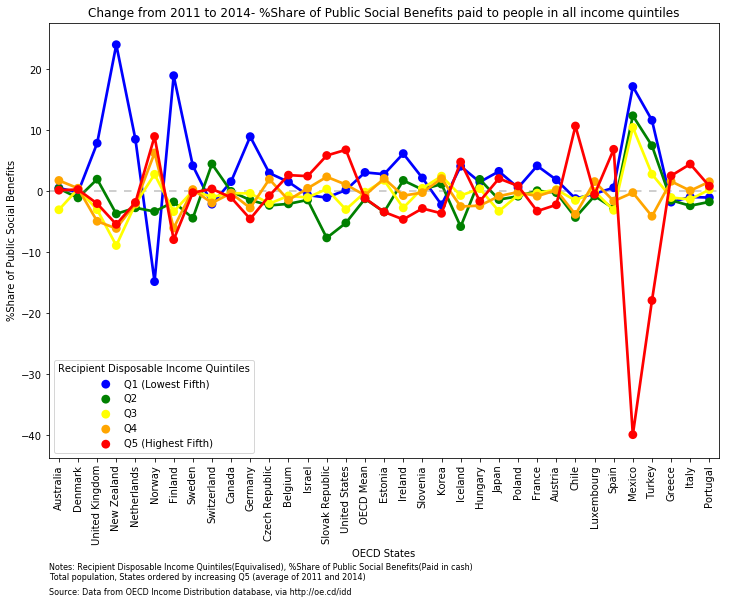

In [511]:
year = "difference"
show_all_quintiles = True
diff = False
figsize = (12,8)
plot_fn = sns.pointplot

plot_script()

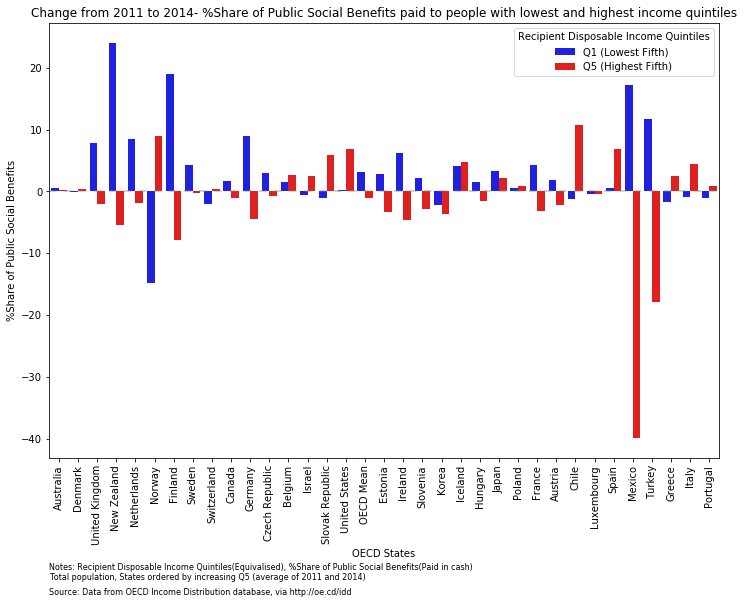

In [512]:
year = "difference"
show_all_quintiles = False
diff = False
figsize = (12,8)
plot_fn = sns.barplot

plot_script()
